In [1]:
import numpy as np

from yadlt.model import generate_pdf_model, mc_integrate_from_mvg, compute_K_by_layer, compute_kernel_from_recursion
from yadlt.plotting.plotting import produce_mat_plot
from yadlt.plotting.plot_kernel_recursion import plot_kernel_at_layer
from yadlt.context import FitContext

In [2]:
import logging
from yadlt.log import setup_logger

# Set up the root logger to capture all logs in jupyter notebook
logger = setup_logger()

# If you want to see all messages, including DEBUG:
logger.setLevel(logging.INFO)

In [3]:
fitname = "250713-01-L0-nnpdf-like"

In [4]:
# Load context
context = FitContext(fitname, force_serialize=False)

In [5]:
fk_grid = context.load_fk_grid()

In [6]:
architecture_tuple = tuple(context.get_config("metadata", "model_info")["architecture"])
seed = context.get_config("metadata", "arguments")["seed"]

nreplicas = 100
x = np.array(fk_grid).reshape(1, -1, 1)
model_ens = []

for rep in range(nreplicas):
    model = generate_pdf_model(
        outputs=1,
        architecture=[500],
        activations=["tanh", "tanh"],
        kernel_initializer="GlorotNormal",
        user_ki_args=None,
        seed=seed + rep,
        scaled_input=False,
        preprocessing=False,
    )

    model_ens.append(model)

# First layer

### Computed by hand

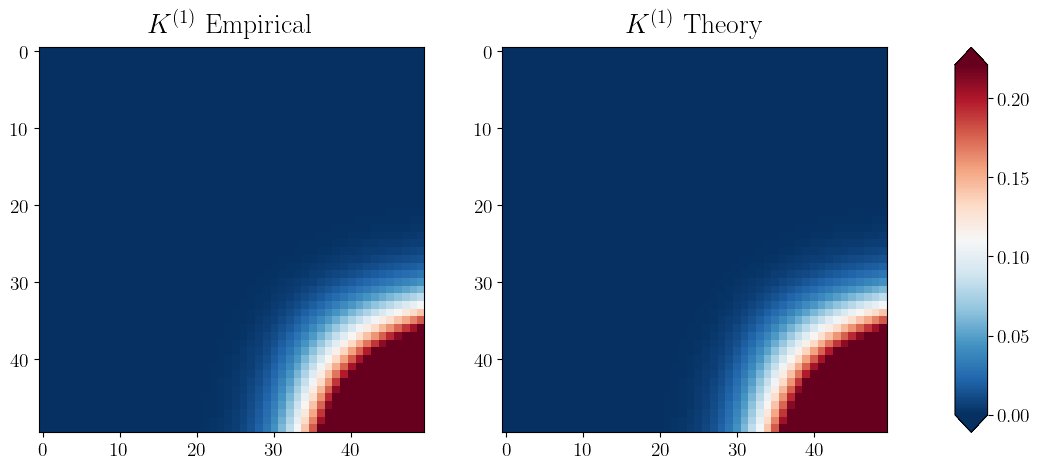

In [7]:
K1_empirical = compute_K_by_layer(model_ens, 0, fk_grid).numpy().squeeze()
K1_infinity = np.outer(fk_grid, fk_grid)

produce_mat_plot(
    [K1_empirical, K1_infinity],
    [r"$K^{(1)} \textrm{ Empirical}$", r"$K^{(1)} \textrm{ Theory}$"],
)

### Using the recursion function

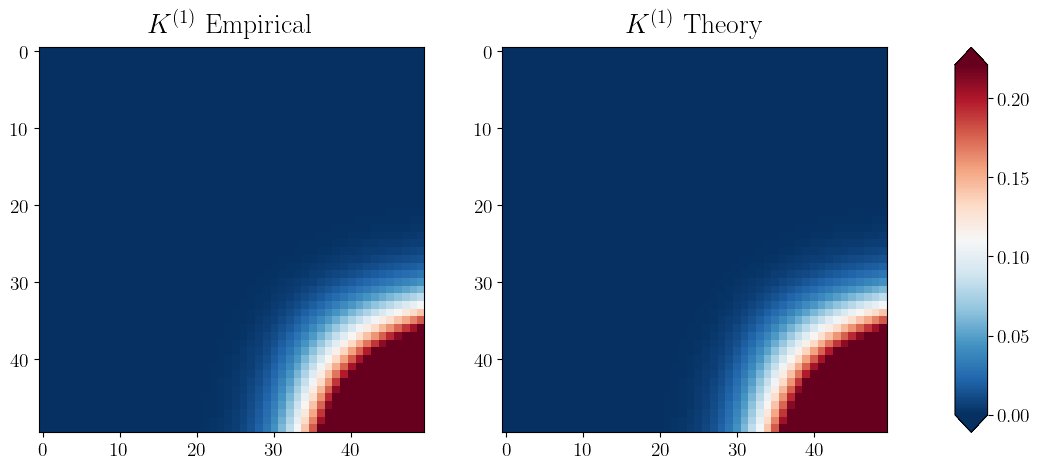

In [8]:
K1_infinity_from_recursion = compute_kernel_from_recursion(
    tuple(model_ens), 0, tuple(fk_grid), num_samples=1000, batch_size=100
)

produce_mat_plot(
    [K1_empirical, K1_infinity_from_recursion],
    [r"$K^{(1)} \textrm{ Empirical}$", r"$K^{(1)} \textrm{ Theory}$"],
)

### Using utility function

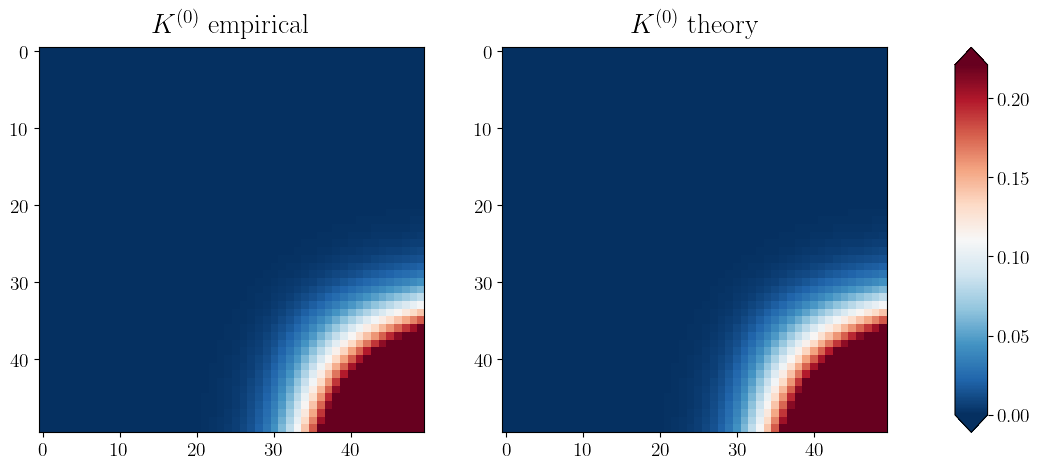

In [9]:
plot_kwargs_list = [
    {"save_fig": False},
    {}
]
plot_kernel_at_layer(
    model_ens,
    layer_idx=0,
    input_data=fk_grid,
    num_samples=1000,
    batch_size=100,
    diag_idx=0,
    offdiag_idx=None,
    plot_kwargs_list=plot_kwargs_list,
)

# Second layer (first deep layer)

## Construction by hand

### Compute the empirical kernel

In [10]:
# Second layer
K2_empirical = compute_K_by_layer(model_ens, 1, fk_grid)

# Plot one diagonal element and one off-diagonal element
K2_diag = K2_empirical[:,0,:,0].numpy()
K2_offdiag = K2_empirical[:,0,:,50].numpy()

### Compute the theoretical kernel

In [11]:
def activation_moment(x):
    """
    Compute the activation moment for a given input x.
    """
    return np.outer(np.tanh(x), np.tanh(x))

rho_rho_mean, rho_rho_std = mc_integrate_from_mvg(activation_moment, 
                                                  np.zeros(K1_empirical.shape[0]), 
                                                  K1_infinity, 
                                                  num_samples=10000,
                                                  batch_size=100)

In [12]:
Cw = 2 / (500 + 1)
K2_infinity = Cw * rho_rho_mean

In [13]:
K2_infinity_from_recursion = compute_kernel_from_recursion(
    tuple(model_ens), 1, tuple(fk_grid), num_samples=10000, batch_size=100
)

### Plot the empirical and theoretical kernels

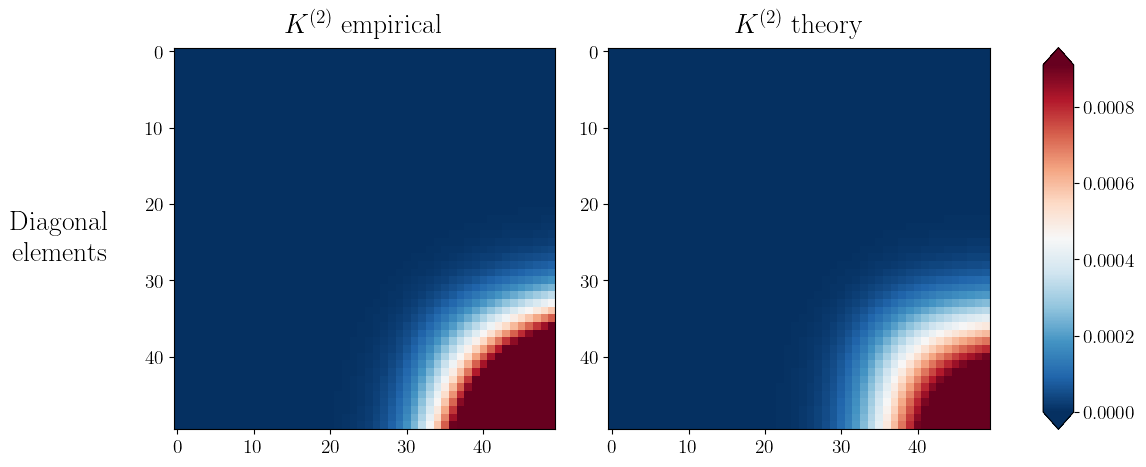

In [14]:
produce_mat_plot([K2_diag, K2_infinity_from_recursion], 
                 [r"$K^{(2)}~\rm{empirical}$", r"$K^{(2)}~\rm{theory}$"],
                 text_dict={"x": -0.3, "y": 0.5, "s": r"$\textrm{Diagonal}$" + "\n" + r"$\rm{elements}$"})

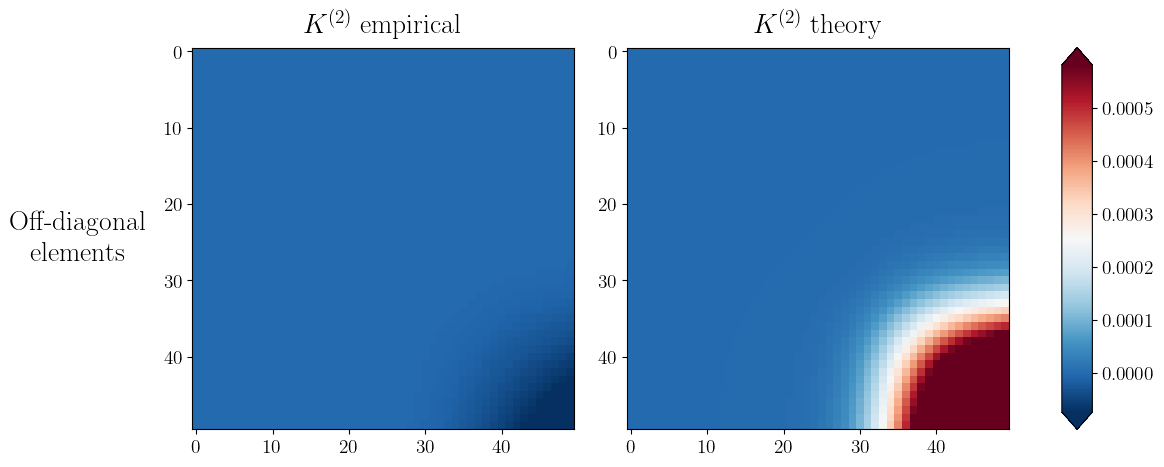

In [15]:
produce_mat_plot([K2_offdiag, K2_infinity_from_recursion], 
                 [r"$K^{(2)}~\rm{empirical}$", r"$K^{(2)}~\rm{theory}$"],
                 text_dict={"x": -0.3, "y": 0.5, "s": r"$\textrm{Off-diagonal}$" + "\n" + r"$\rm{elements}$"})

## Using the utility function

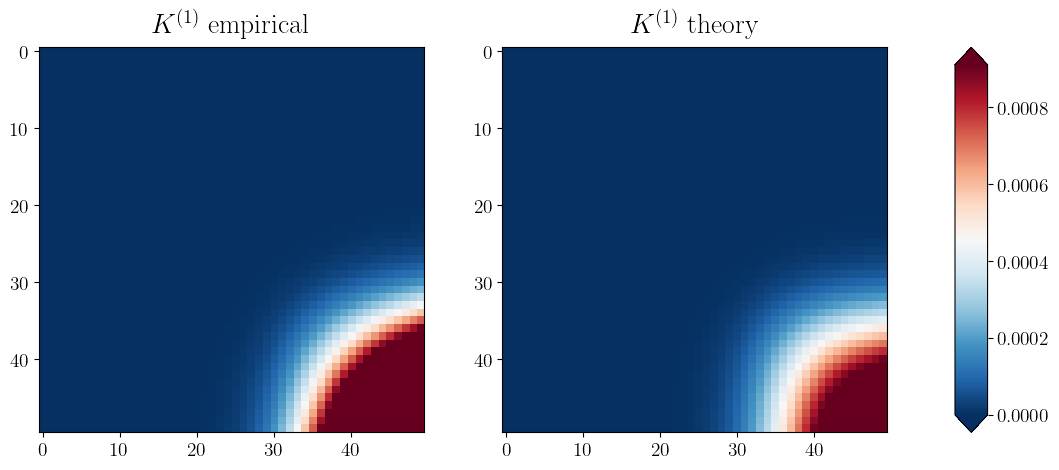

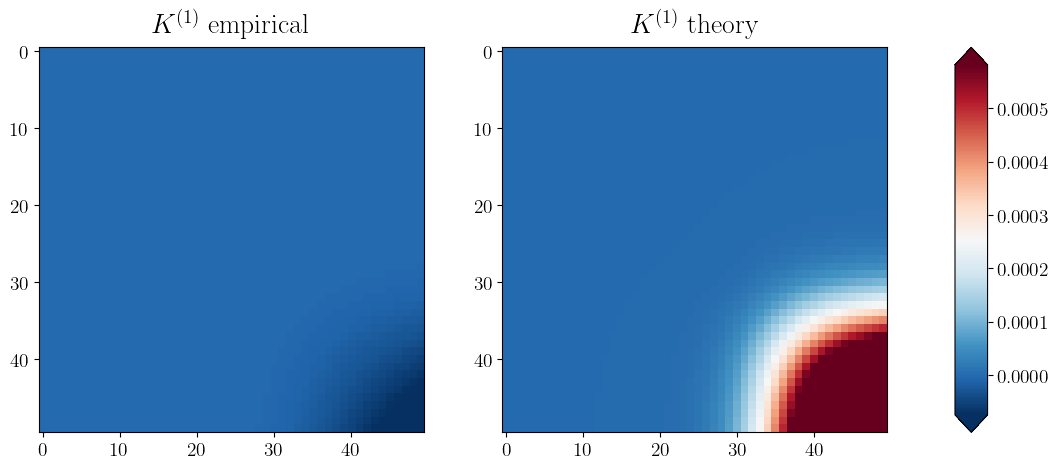

In [16]:
plot_kwargs_list = [{"save_fig": False}, {"save_fig": False},]
plot_kernel_at_layer(
    model_ens,
    layer_idx=1,
    input_data=fk_grid,
    num_samples=10000,
    batch_size=100,
    diag_idx=0,
    offdiag_idx=50,
    plot_kwargs_list=plot_kwargs_list,
)